In [ ]:
%%shell
git clone --branch vmphat --single-branch https://github.com/vphuhan/21KHDL-TikTok-Analytics.git
cd 21KHDL-TikTok-Analytics
git sparse-checkout init --cone
git sparse-checkout set data/interim
git checkout


Cloning into '21KHDL-TikTok-Analytics'...
remote: Enumerating objects: 885, done.
remote: Counting objects: 100% (278/278), done.
remote: Compressing objects: 100% (113/113), done.
remote: Total 885 (delta 209), reused 168 (delta 164), pack-reused 607 (from 1)
Receiving objects: 100% (885/885), 53.48 MiB | 14.30 MiB/s, done.
Resolving deltas: 100% (457/457), done.
Your branch is up to date with 'origin/vmphat'.


In [ ]:
#@title Import
import os
from glob import glob

import pandas as pd
import numpy as np
import json
import re

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import plotly.express as px
import plotly.graph_objects as go

from tqdm import tqdm
from collections import Counter

In [ ]:
#@title Plotly theme
plotly_theme = "seaborn" # @param ['ggplot2', 'seaborn', 'simple_white', 'plotly', 'plotly_white', 'plotly_dark', 'presentation', 'xgridoff', 'ygridoff', 'gridon', 'none']

In [ ]:
#@title Dataset
user_info_df = pd.read_csv("/content/21KHDL-TikTok-Analytics/data/interim/user_info.csv")
audio_text_df = pd.read_csv("/content/21KHDL-TikTok-Analytics/data/interim/audio_text.csv")

In [ ]:
user_info_df.head(5)

,extra.logid,extra.now,log_pb.impr_id,shareMeta.desc,shareMeta.title,statusCode,status_code,status_msg,userInfo.stats.diggCount,userInfo.stats.followerCount,...,userInfo.user.verified,userInfo.user.profileTab.showMusicTab,userInfo.user.bioLink.link,userInfo.user.profileTab.showQuestionTab,userInfo.user.roomId,userInfo.user.commerceUserInfo.category,userInfo.user.commerceUserInfo.categoryButton,userInfo.user.commerceUserInfo.downLoadLink.android,userInfo.user.commerceUserInfo.downLoadLink.ios,userInfo.user.uniqueIdModifyTime
0,20250213003332323F8E538821A316BC96,1739378012000,20250213003332323F8E538821A316BC96,"@amthucphatgiao.kt 2.9m Followers, 40 Followin...",Thích Khải Tuấn🌱 on TikTok,0,0,NaN,0,2900000,...,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,202502122356399F6A1620C1DD1C14DDD9,1739375799000,202502122356399F6A1620C1DD1C14DDD9,"@andreerighthand 568.4k Followers, 1 Following...",Andree Right Hand on TikTok,0,0,NaN,0,568400,...,True,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,20250213005955A9051D756555BB13DA8A,1739379595000,20250213005955A9051D756555BB13DA8A,"@angelmikeden 560.5k Followers, 2 Following, 4...",Anh Mike Chị Angel on TikTok,0,0,NaN,0,560500,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,202502130037427C1E832C485AF014C9BC,1739378262000,202502130037427C1E832C485AF014C9BC,"@anhbaphaitv_ofc 1.5m Followers, 0 Following, ...",Phạm Văn Phú on TikTok,0,0,NaN,0,1500000,...,False,NaN,vanphu18592@gmail.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,20250212231226119300FDED211C10D4BD,1739373146000,20250212231226119300FDED211C10D4BD,"@anhmoney 1.3m Followers, 50 Following, 37.5m ...",Anh Money 💰 on TikTok,0,0,NaN,0,1300000,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
user_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 49 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   extra.logid                                          99 non-null     object 
 1   extra.now                                            99 non-null     int64  
 2   log_pb.impr_id                                       99 non-null     object 
 3   shareMeta.desc                                       99 non-null     object 
 4   shareMeta.title                                      99 non-null     object 
 5   statusCode                                           99 non-null     int64  
 6   status_code                                          99 non-null     int64  
 7   status_msg                                           0 non-null      float64
 8   userInfo.stats.diggCount                             99 non-null     int

In [ ]:
#@title Drop NaN field
threshold = "80"  #@param ["100", "95", "90", "85", "80"]
threshold_percentage = int(threshold)/100
cleaned_user_info_df = user_info_df.dropna(axis=1, thresh= threshold_percentage)
print(f"Removed {user_info_df.shape[1] - cleaned_user_info_df.shape[1]} columns that have more than {threshold}% NaN values")


Removed 3 columns that have more than 80% NaN values


In [ ]:
#@title Check and remove duplicate
duplicates = cleaned_user_info_df[cleaned_user_info_df.duplicated()]
cleaned_user_info_df = cleaned_user_info_df.drop_duplicates()
print(f"Removed: {duplicates.shape[0]} duplicated sample.")


Removed: 0 duplicated sample.


In [ ]:
cleaned_user_info_df.columns

Index(['extra.logid', 'extra.now', 'log_pb.impr_id', 'shareMeta.desc',
       'shareMeta.title', 'statusCode', 'status_code',
       'userInfo.stats.diggCount', 'userInfo.stats.followerCount',
       'userInfo.stats.followingCount', 'userInfo.stats.friendCount',
       'userInfo.stats.heart', 'userInfo.stats.heartCount',
       'userInfo.stats.videoCount', 'userInfo.user.bioLink.risk',
       'userInfo.user.canExpPlaylist', 'userInfo.user.commentSetting',
       'userInfo.user.commerceUserInfo.commerceUser',
       'userInfo.user.downloadSetting', 'userInfo.user.duetSetting',
       'userInfo.user.followingVisibility', 'userInfo.user.ftc',
       'userInfo.user.id', 'userInfo.user.isADVirtual',
       'userInfo.user.isEmbedBanned', 'userInfo.user.nickNameModifyTime',
       'userInfo.user.nickname', 'userInfo.user.openFavorite',
       'userInfo.user.privateAccount', 'userInfo.user.profileEmbedPermission',
       'userInfo.user.profileTab.showPlayListTab', 'userInfo.user.relation',
   

### **1. Descriptive Analysis**  
- Distribution of `userInfo.stats.followerCount`, `userInfo.stats.heart`, and `userInfo.stats.videoCount`.  
- Check how many users have verified accounts (`userInfo.user.verified`).  
- Count of private vs. public accounts (`userInfo.user.privateAccount`).

In [ ]:
# Set custom color palette
colors = ["#636EFA", "#EF553B", "#00CC96"]  # Blue, Red, Green

# Distribution of Followers
fig_followers = px.histogram(cleaned_user_info_df,
                             x='userInfo.stats.followerCount',
                             nbins=50,
                             title="Distribution of Followers",
                             log_y=True,
                             labels={'userInfo.stats.followerCount': 'Follower Count'},
                             color_discrete_sequence=[colors[0]])  # Blue
fig_followers.update_layout(template= plotly_theme, bargap=0.1)
fig_followers.show()

# Distribution of Likes (Hearts)
fig_likes = px.histogram(cleaned_user_info_df,
                         x='userInfo.stats.heart',
                         nbins=50,
                         title="Distribution of Likes (Hearts)",
                         log_y=True,
                         labels={'userInfo.stats.heart': 'Likes'},
                         color_discrete_sequence=[colors[1]])  # Red
fig_likes.update_layout(template= plotly_theme, bargap=0.1)
fig_likes.show()

# Distribution of Video Count
fig_videos = px.histogram(cleaned_user_info_df,
                          x='userInfo.stats.videoCount',
                          nbins=50,
                          title="Distribution of Video Count",
                          log_y=True,
                          labels={'userInfo.stats.videoCount': 'Video Count'},
                          color_discrete_sequence=[colors[2]])  # Green
fig_videos.update_layout(template= plotly_theme, bargap=0.1)
fig_videos.show()


In [ ]:
# Count Verified vs Non-Verified Users
verified_counts = cleaned_user_info_df['userInfo.user.verified'].value_counts()

# Define colors (Blue for Verified, Red for Non-Verified)
colors = ["#EF553B", "#636EFA"]  # Red for Non-Verified, Blue for Verified

# Create Pie Chart with Improved Styling
fig_verified = px.pie(
    values=verified_counts.values,
    names=verified_counts.index.astype(str),  # Dynamically set labels
    title="Verified vs Non-Verified Users",
    color=verified_counts.index.astype(str),  # Assign colors dynamically
    color_discrete_map={"False": colors[0], "True": colors[1]},  # Map colors correctly
)

# Enhance layout
fig_verified.update_traces(textinfo='percent+label', pull=[0.02, 0])  # Slightly separate slices
fig_verified.update_layout(template= plotly_theme)  # Apply dark theme
fig_verified.show()


### **2. Engagement & Popularity Analysis**  
- Correlation between `userInfo.stats.followerCount`, `userInfo.stats.heart`, and `userInfo.stats.videoCount`.  
- Identify top users with the most likes (`userInfo.stats.heart`) or most videos (`userInfo.stats.videoCount`).  
- Find users with high `userInfo.stats.followerCount` but low engagement (`userInfo.stats.heart`).  

In [ ]:
# Load Data (Assuming 'cleaned_user_info_df' is already loaded)
df = cleaned_user_info_df.copy()

### 1. Correlation Analysis between Followers, Likes, and Videos
correlation_matrix = df[['userInfo.stats.followerCount', 'userInfo.stats.heart', 'userInfo.stats.videoCount']].corr()

fig_corr = px.imshow(correlation_matrix,
                     text_auto=True,
                     aspect="auto",
                     title="Correlation Between Followers, Likes, and Videos",
                     color_continuous_scale="blues")  # Use a blue color scale
fig_corr.show()

### **Insights:**
1. **Strong Correlation Between Followers and Likes (`0.7398`)**  
   - This suggests that users with more followers tend to receive more likes (`hearts`).  
   - However, since it is not a perfect correlation (`<1`), other factors (e.g., engagement rate, content quality) also influence likes.

2. **Weak Correlation Between Followers and Videos (`0.0068`)**  
   - This means the number of followers is **not strongly related** to the number of videos posted.  
   - Users with many videos may have **low followers**, and some high-follower accounts may have **fewer videos** (possibly viral accounts).

3. **Moderate Correlation Between Likes and Videos (`0.3111`)**  
   - Posting more videos has some impact on the number of likes, but it is not the strongest factor.  
   - Content quality and engagement rate may play a more significant role.

### **Key Takeaways for Growth on TikTok:**
- **Gaining followers is crucial** for getting more likes.  
- **Posting more videos does not necessarily increase followers** but can **moderately** boost total likes.  
- **Focus on engagement (likes per follower) rather than just increasing video count.**  

In [ ]:
### 2. Identify Top Users with Most Likes
top_likes = df.nlargest(10, 'userInfo.stats.heart')[['userInfo.user.uniqueId', 'userInfo.stats.heart']]

fig_top_likes = px.bar(top_likes,
                       x='userInfo.user.uniqueId',
                       y='userInfo.stats.heart',
                       title="Top 10 Users with Most Likes",
                       color='userInfo.stats.heart',
                       color_continuous_scale='reds')

fig_top_likes.update_layout(xaxis_title="User ID", yaxis_title="Total Likes (Hearts)", template= plotly_theme)
fig_top_likes.show()

### 3. Identify Top Users with Most Videos
top_videos = df.nlargest(10, 'userInfo.stats.videoCount')[['userInfo.user.uniqueId', 'userInfo.stats.videoCount']]

fig_top_videos = px.bar(top_videos,
                         x='userInfo.user.uniqueId',
                         y='userInfo.stats.videoCount',
                         title="Top 10 Users with Most Videos",
                         color='userInfo.stats.videoCount',
                         color_continuous_scale='greens')

fig_top_videos.update_layout(xaxis_title="User ID", yaxis_title="Total Videos", template= plotly_theme)
fig_top_videos.show()

### 4. Find Users with High Followers but Low Engagement (Likes)
df['engagement_ratio'] = df['userInfo.stats.heart'] / df['userInfo.stats.followerCount']
low_engagement_users = df[df['engagement_ratio'] < df['engagement_ratio'].quantile(0.25)]  # Bottom 25%

fig_low_engagement = px.scatter(low_engagement_users,
                                x='userInfo.stats.followerCount',
                                y='userInfo.stats.heart',
                                title="Users with High Followers but Low Engagement",
                                size='userInfo.stats.followerCount',
                                color='engagement_ratio',
                                color_continuous_scale='oranges',
                                hover_data=['userInfo.user.uniqueId'])

fig_low_engagement.update_layout(xaxis_title="Follower Count", yaxis_title="Total Likes (Hearts)", template= plotly_theme)
fig_low_engagement.show()


### **3. User Behavior Analysis**  
- Most common `userInfo.user.commentSetting` and `userInfo.user.duetSetting`.  
- Analyze how many users have enabled downloading (`userInfo.user.downloadSetting`).  
- Compare settings of verified vs. non-verified users (`userInfo.user.verified`).  
- Track account modifications: `userInfo.user.nickNameModifyTime`, `userInfo.user.uniqueIdModifyTime`.  


In [ ]:
df = cleaned_user_info_df.copy()

### 2. Analyze How Many Users Have Enabled Downloading
download_counts = df['userInfo.user.downloadSetting'].value_counts()

fig_download = px.pie(values=download_counts.values,
                      names=download_counts.index.astype(str),
                      title="Download Enabled vs Disabled",
                      color=download_counts.index.astype(str),
                      color_discrete_map={"0": "#EF553B", "1": "#00CC96"})  # Red = Disabled, Green = Enabled

fig_download.update_traces(textinfo='percent+label', pull=[0.05, 0])
fig_download.update_layout(template= plotly_theme)
fig_download.show()

### 3. Compare Settings of Verified vs. Non-Verified Users
verified_settings = df.groupby("userInfo.user.verified")[['userInfo.user.commentSetting', 'userInfo.user.duetSetting', 'userInfo.user.downloadSetting']].mean().reset_index()

fig_verified_settings = px.bar(verified_settings.melt(id_vars="userInfo.user.verified"),
                               x="userInfo.user.verified",
                               y="value",
                               color="variable",
                               barmode="group",
                               title="Comparison of Settings: Verified vs. Non-Verified Users",
                               color_discrete_sequence=["#FFA15A", "#636EFA", "#00CC96"])  # Orange, Blue, Green

fig_verified_settings.update_layout(xaxis_title="Verified Status", yaxis_title="Avg Setting Value", template=plotly_theme)
fig_verified_settings.show()

### 4. Track Account Modifications
df["userInfo.user.nickNameModifyTime"] = pd.to_datetime(df["userInfo.user.nickNameModifyTime"], unit="s")
df["userInfo.user.uniqueIdModifyTime"] = pd.to_datetime(df["userInfo.user.uniqueIdModifyTime"], unit="s")

fig_modifications = px.histogram(df,
                                 x="userInfo.user.nickNameModifyTime",
                                 title="Nickname Modification Over Time",
                                 color_discrete_sequence=["#AB63FA"])

fig_unique_modifications = px.histogram(df,
                                        x="userInfo.user.uniqueIdModifyTime",
                                        title="Unique ID Modification Over Time",
                                        color_discrete_sequence=["#19D3F3"])

fig_modifications.update_layout(xaxis_title="Date", yaxis_title="Count", template= plotly_theme)
fig_unique_modifications.update_layout(xaxis_title="Date", yaxis_title="Count", template= plotly_theme)

fig_modifications.show()
fig_unique_modifications.show()


#### **More: Comment setting la gi?**

Bạn có thể cho phép người khác bình luận video của mình để tương tác và xây dựng kết nối với Cộng đồng TikTok.

#### **More: Download setting la gi?**

Trên TikTok, cài đặt tải xuống cho phép bạn kiểm soát ai có thể tải xuống video hoặc ảnh của bạn. Khi bạn bật cài đặt này, người khác có thể lưu nội dung của bạn vào thiết bị của họ, chuyển đổi video của bạn thành ảnh động (GIF) hoặc ảnh sống (Live Photos), và chia sẻ trực tiếp trên các nền tảng khác.

Nếu bạn tắt cài đặt tải xuống, người khác sẽ không thể tải xuống hoặc chuyển đổi video của bạn. Tuy nhiên, họ vẫn có thể chia sẻ nội dung của bạn qua liên kết hoặc tin nhắn trực tiếp trên các nền tảng khác

What Download mode typically mean?

0 → Downloads allowed for everyone  
1 → Downloads restricted (e.g., only certain users can download)  
3 → Downloads disabled  
18 → Possibly a newer or region-specific setting  


#### **More: Duet Là Gì?**

Duet trên TikTok là tính năng thú vị gần đây được các bạn trẻ yêu thích và sử dụng rất nhiều nhờ vào tính kết nối cao vì tính năng này cho phép người dùng TikTok có thể quay video duet với người nổi tiếng hay người dùng khác.

Sử dụng tính năng Duet trên TikTok cho phép bạn tương tác với người khác bằng cách song ca, hát nhép hay nhảy múa theo phong cách mà bạn muốn, đồng thời tạo ra những video độc đáo không bị trùng với bất kỳ ai.


### **4. Text & Profile Analysis**  
- Most common words in `userInfo.user.signature` (profile bios).  
- Count of users who have added a bio link (`userInfo.user.bioLink.link`).  
- Distribution of `userInfo.user.profileEmbedPermission`.  

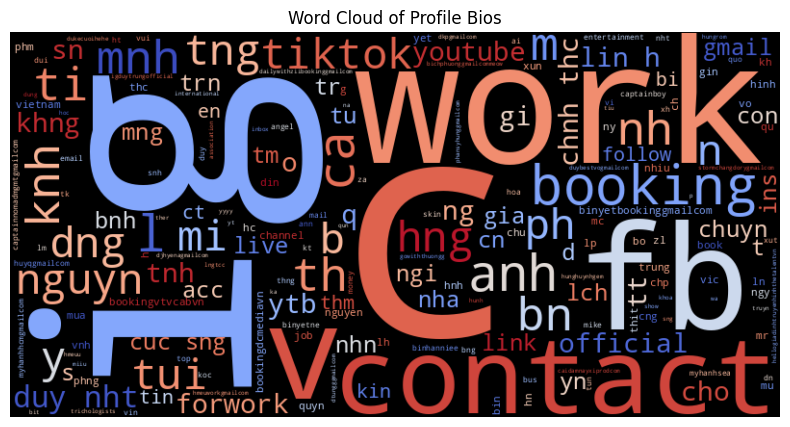

In [ ]:
df = cleaned_user_info_df.copy()

### 1. Most Common Words in `userInfo.user.signature` (Profile Bios)
bio_text = " ".join(df["userInfo.user.signature"].dropna())

# Clean text (remove special characters and numbers)
bio_text_clean = re.sub(r"[^a-zA-Z\s]", "", bio_text.lower())

# Count word frequencies
word_counts = Counter(bio_text_clean.split())
common_words = pd.DataFrame(word_counts.most_common(20), columns=["Word", "Frequency"])

# Generate Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color="black", colormap="coolwarm").generate(bio_text_clean)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Profile Bios")
plt.show()

**Some frequently used words in the bios:**

- Social Media Handles: IG (Instagram), FB (Facebook), TikTok, YouTube.
- Contact Information: Contact, Booking.
- Work-related Terms: Work, Official.
-Interests: Words related to hobbies and activities such as Live, Booking.

In [ ]:
df = cleaned_user_info_df.copy()

### 1. Most Common Words in `userInfo.user.signature` (Profile Bios)
bio_text = " ".join(df["userInfo.user.signature"].dropna())

# Clean text (remove special characters and numbers)
bio_text_clean = re.sub(r"[^a-zA-Z\s]", "", bio_text.lower())

# Count word frequencies
word_counts = Counter(bio_text_clean.split())
common_words = pd.DataFrame(word_counts.most_common(20), columns=["Word", "Frequency"])

# Plot using Bar Chart
fig_words = px.bar(common_words,
                   x="Word",
                   y="Frequency",
                   title="Most Common Words in Profile Bios",
                   color="Frequency",
                   color_continuous_scale="tealrose")

fig_words.update_layout(xaxis_title="Word", yaxis_title="Frequency", template= plotly_theme)
fig_words.show()


### 2. Count of Users Who Have Added a Bio Link
bio_link_counts = df["userInfo.user.bioLink.link"].notna().value_counts()

fig_bio_links = px.pie(values=bio_link_counts.values,
                        names=["No Bio Link", "Has Bio Link"],
                        title="Users with Bio Links",
                        color=["No Bio Link", "Has Bio Link"],
                        color_discrete_map={"No Bio Link": "#EF553B", "Has Bio Link": "#00CC96"})  # Red & Green

fig_bio_links.update_traces(textinfo="percent+label", pull=[0.05, 0])
fig_bio_links.update_layout(template= plotly_theme)
fig_bio_links.show()

### 3. Distribution of `userInfo.user.profileEmbedPermission`
embed_permission_counts = df["userInfo.user.profileEmbedPermission"].value_counts()

fig_embed_permission = px.bar(embed_permission_counts,
                              x=embed_permission_counts.index.astype(str),
                              y=embed_permission_counts.values,
                              title="Distribution of Profile Embed Permissions",
                              color=embed_permission_counts.values,
                              color_continuous_scale="sunsetdark")

fig_embed_permission.update_layout(xaxis_title="Profile Embed Permission", yaxis_title="Count", template= plotly_theme)
fig_embed_permission.show()


#### **More: TikTok Embeds**
Show content from TikTok on your websites. Curate from popular videos, profiles, hashtags, and sounds. Or, create your own playlists for others to discover. Embeds give you the freedom to choose the content to show your audience.


### **5. Commerce & Monetization Analysis**  
- Number of TikTok Shop sellers (`userInfo.user.ttSeller`).  
- Count users participating in commerce (`userInfo.user.commerceUserInfo.commerceUser`).  
- Most common commerce categories (`userInfo.user.commerceUserInfo.category`).

In [ ]:
df = cleaned_user_info_df.copy()

### 1. Count of TikTok Shop Sellers (`userInfo.user.ttSeller`)
seller_counts = df["userInfo.user.ttSeller"].value_counts()

# Ensure the names dynamically match the unique values
fig_sellers = px.pie(values=seller_counts.values,
                     names=seller_counts.index.astype(str),  # Dynamically fetch labels
                     title="TikTok Shop Sellers vs. Non-Sellers",
                     color=seller_counts.index.astype(str),
                     color_discrete_sequence=px.colors.qualitative.Set2)

fig_sellers.update_traces(textinfo="percent+label", pull=[0.05] * len(seller_counts))
fig_sellers.update_layout(template= plotly_theme)
fig_sellers.show()


### 2. Count Users Participating in Commerce (`userInfo.user.commerceUserInfo.commerceUser`)
commerce_counts = df["userInfo.user.commerceUserInfo.commerceUser"].value_counts()

fig_commerce = px.pie(values=commerce_counts.values,
                      names=["Not in Commerce", "Commerce User"],
                      title="Commerce Participation",
                      color=["Not in Commerce", "Commerce User"],
                      color_discrete_map={"Not in Commerce": "#636EFA", "Commerce User": "#FFA15A"})  # Blue & Orange

fig_commerce.update_traces(textinfo="percent+label", pull=[0.05, 0])
fig_commerce.update_layout(template= plotly_theme)
fig_commerce.show()

### 3. Most Common Commerce Categories (`userInfo.user.commerceUserInfo.category`)
commerce_categories = df["userInfo.user.commerceUserInfo.category"].dropna().value_counts().head(10)  # Top 10 categories

fig_categories = px.bar(commerce_categories,
                        x=commerce_categories.index.astype(str),
                        y=commerce_categories.values,
                        title="Most Common Commerce Categories",
                        color=commerce_categories.values,
                        color_continuous_scale="armyrose")

fig_categories.update_layout(xaxis_title="Commerce Category", yaxis_title="Count", template= plotly_theme)
fig_categories.show()


#### **TikTok Shop for Creators vs Sellers: What You Need to Know [2025]**

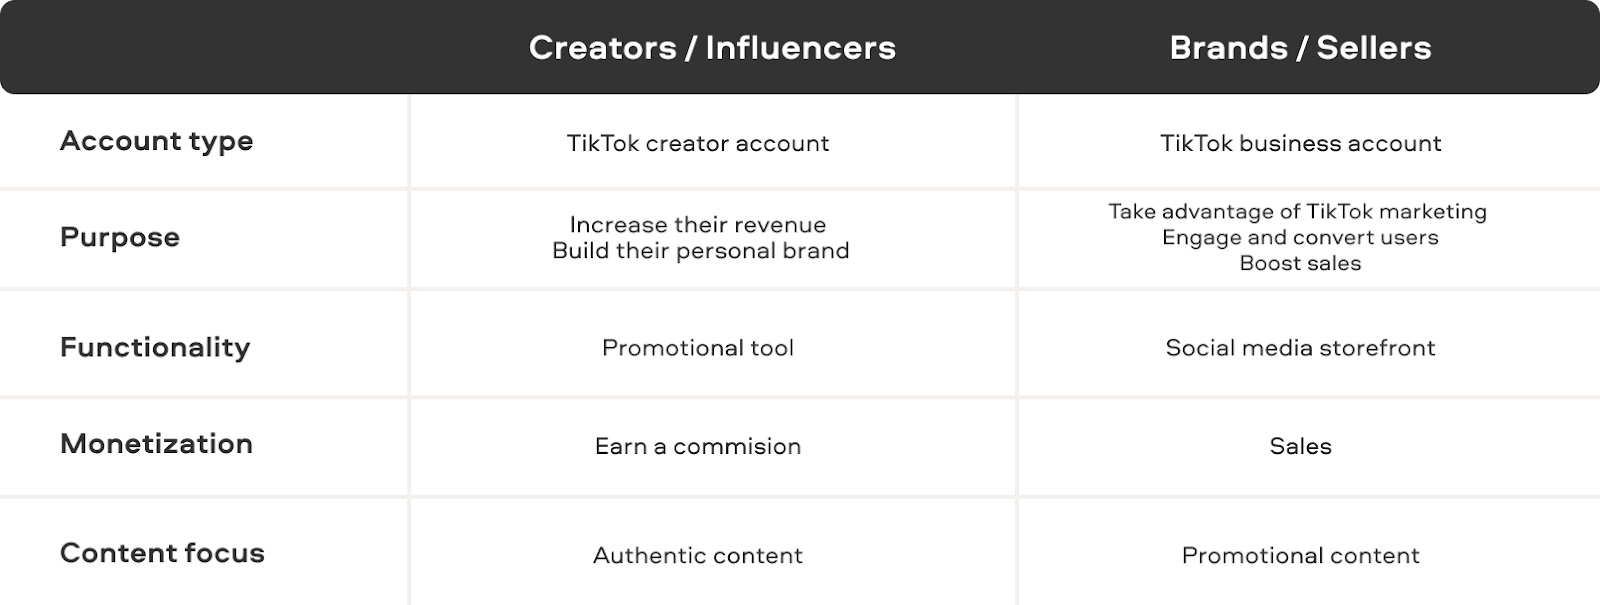

### **TikTok Commerce**

TikTok Commerce is a program designed with solutions, features, and advertising tools that brands can utilize to engage with their customers effectively. Brands can sell products through TikTok videos, live streams, and on their profile page's product showcase tab.

**Note**: TikTok Commerce (formerly TikTok Shopping) is available for select markets and platforms.

#### Benefits and Features
TikTok Commerce offers two primary paths for selling products directly on your TikTok account:

1. **Shop Ads**
   - Create Shop Ads by selecting the Product sales objective in TikTok Ads Manager.
   - Features:
     - Personalized recommendations based on user interactions.
     - Automated functionalities like creative automation and dynamic product landing pages.
     - Optimized delivery strategies to maximize impact.

2. **TikTok Shop**
   - Run an e-commerce business directly on TikTok with TikTok Seller Center and Affiliate Center.
   - Features:
     - Discover products from Livestreams, video content, and showcase tabs.
     - A fully native shopping experience where TikTok handles product discovery, management, shipping, billing, purchases, and returns.
   - Available Markets: Indonesia, Malaysia, the Philippines, Singapore, Thailand, the United Kingdom, the United States, and Vietnam.
   - Marketplace Tools:
     - **TikTok Seller Center**: End-to-end solutions to launch and manage TikTok Shop.
     - **TikTok Affiliate Program**: Connect with creators for commission-based product marketing content.
     - **Native Checkout Flow**: Complete checkout and payment directly on TikTok Shop.

For more details, you can visit [TikTok Commerce](https://ads.tiktok.com/help/article/tiktok-commerce?lang=en).